# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
# from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [3]:
# Load data
df = pd.read_csv('eth.csv')
print(df)
name_col='close'

      Unnamed: 0 formatted_date         high          low         open  \
0              0     2019-01-01   141.397507   132.650711   141.519516   
1              1     2019-01-02   156.929138   140.650955   155.196045   
2              2     2019-01-03   155.863052   147.198364   148.912888   
3              3     2019-01-04   156.878983   147.907104   154.337418   
4              4     2019-01-05   160.824890   154.337418   155.804230   
...          ...            ...          ...          ...          ...   
1515        1515     2023-02-24  1661.091309  1583.147827  1608.658325   
1516        1516     2023-02-25  1608.865112  1567.631714  1594.761108   
1517        1517     2023-02-26  1645.273438  1590.393066  1640.763672   
1518        1518     2023-02-27  1662.575684  1615.387939  1634.502441   
1519        1519     2023-02-28  1644.435791  1602.428101  1606.040405   

            close      volume     adjclose  
0      140.819412  2258709868   140.819412  
1      155.047684  33

In [4]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df[name_col].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df[name_col].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df[name_col].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df[name_col].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df[name_col].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv(f"../../predict/bitcoin_df_{name_col}.csv")
df.set_index('formatted_date')
df2=df.copy()

## Nạp dữ liệu từ file csv

In [5]:

split_x = df2[['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}','formatted_date']]
split_y = df2[[name_col]]

X_train, X_test,y_train, y_test = train_test_split(split_x,split_y ,
                                   random_state=104, 
                                   test_size=0.3, 
                                   shuffle=True)
print(X_train)

             high          low         open         H-L        SMA_7  \
607    428.663971   399.608368   428.509003   29.055603   397.919407   
683    475.161438   452.986084   460.149902   22.175354   458.019937   
706    602.917908   585.428650   591.900818   17.489258   594.583897   
679    453.758362   439.600128   449.679657   14.158234   436.291321   
558    243.311142   237.770218   242.181870    5.540924   241.835227   
...           ...          ...          ...         ...          ...   
186    295.991425   286.665863   287.603607    9.325562   291.300197   
674    417.525940   397.245819   414.066711   20.280121   393.248108   
1295  1607.033081  1501.797485  1542.954346  105.235596  1335.885411   
749   1432.300049  1254.522949  1375.248413  177.777100  1231.330322   
89     142.189209   140.697372   141.465485    1.491837   139.571459   

           SMA_14       SMA_21        SD_7       SD_21 formatted_date  
607    402.706140   406.593472   16.330572   19.535481     2020

## Chuẩn hóa dữ liệu

In [6]:
cols_x = ['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = [name_col]
x_train = X_train[cols_x].values.reshape(-1, len(cols_x))
y_train = y_train[cols_y].values.reshape(-1, len(cols_y))
print(x_train.shape, y_train.shape)

(1050, 9) (1050, 1)


In [7]:

x_test = X_test[cols_x].values.reshape(-1, len(cols_x))
y_test = y_test[cols_y].values.reshape(-1, len(cols_y))
print(x_test.shape, y_test.shape)

(450, 9) (450, 1)


# 2. Quá trình dự đoán trên mô hình 


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
_gdm = ('gradient', GradientBoostingRegressor(learning_rate= 0.07, max_depth= 8, n_estimators= 1000, subsample= 0.3));
_elm = ('elasticnet', ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True));
_lsm = ('lasso', Lasso(alpha= 3.17, copy_X= True, fit_intercept= False, max_iter= 1, normalize= True, positive= False, precompute= False, random_state= None, selection= 'random', tol= 0.3, warm_start= False));
_ridge = ('ridge',Ridge(alpha= 0.0006, copy_X= True, fit_intercept= False, max_iter= 1, normalize= False, positive= True, random_state= None, solver= 'auto', tol= 0.001));
_lr = ('linear',LinearRegression())

In [10]:
from itertools import permutations 
perm = permutations([_lr, _gdm, _lsm, _ridge]) 
_estimator_elm = []
for i in list(perm): 
    _estimator_elm.append(i)

In [11]:
parameters = {'estimators':_estimator_elm,  
              'final_estimator':_elm}
elm_grid = GridSearchCV(StackingRegressor(estimators= None, final_estimator = None),parameters, scoring='r2', cv=None).fit(x_train, y_train.reshape(-1, 1))
print(elm_grid.best_params_)
elm_reg = StackingRegressor(estimators= elm_grid.best_params_["estimators"], final_estimator = elm_grid.best_params_["final_estimator"])
elm_reg.fit(x_train, y_train.reshape(-1, 1))
elm_pred = elm_reg.predict(x_test)

{'estimators': (('ridge', Ridge(alpha=0.0006, fit_intercept=False, max_iter=1, normalize=False,
      positive=True)), ('gradient', GradientBoostingRegressor(learning_rate=0.07, max_depth=8, n_estimators=1000,
                          subsample=0.3)), ('linear', LinearRegression()), ('lasso', Lasso(alpha=3.17, fit_intercept=False, max_iter=1, normalize=True,
      selection='random', tol=0.3))), 'final_estimator': ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)}


,high,low,open,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21,formatted_date,predict
517,248.236282,230.488052,246.828186,17.748230,224.513480,215.612821,210.857996,16.622159,14.556007,2020-06-01,247.078579
987,3429.169678,3273.630859,3431.217285,155.538818,3361.607875,3592.315970,3477.037051,105.134044,285.679414,2021-09-14,3426.173928
1146,2763.756592,2585.946289,2627.665527,177.810303,2900.106480,2972.212402,2929.004639,198.732949,183.442140,2022-02-20,2628.200600
610,480.330994,424.460022,440.239990,55.870972,422.713806,409.313841,415.397108,32.363495,24.347204,2020-09-02,440.510480
1470,1342.757202,1318.527222,1336.486816,24.229980,1283.728446,1243.148917,1235.042998,33.340218,40.695427,2023-01-10,1335.738514


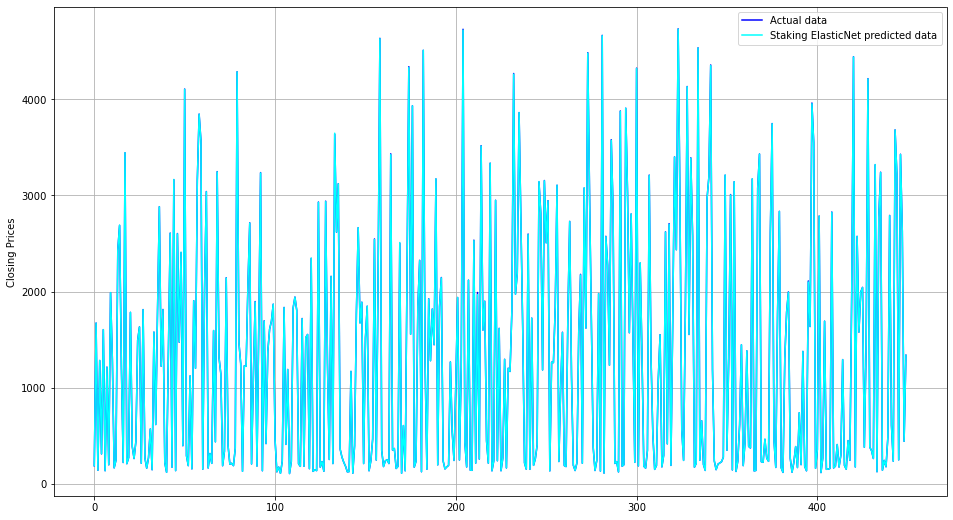

In [12]:

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(y_test, 'blue', label='Actual data')
plt.plot(elm_pred, 'cyan', label='Staking ElasticNet predicted data')
plt.legend()
X_test['predict']=elm_pred
X_test.tail()

In [13]:
import pickle


In [14]:
mae = mean_absolute_error(y_test, elm_pred)
mape = mean_absolute_percentage_error(y_test, elm_pred)
mse = mean_squared_error(y_test, elm_pred)
rmse = np.sqrt(mse)
# r2 = r2_score(y_test, elm_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
# print(f"R2: {r2:.2f}")

MAE: 1.30
MAPE: 0.14%
MSE: 5.68
RMSE: 2.38
